In [1]:
import pandas as pd
import numpy as np
from data_generator.batch_generator import BatchGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from models import AlexNet, LeNet
from squeezenet_master.model import *

from keras.layers.advanced_activations import LeakyReLU, ELU
from keras import backend as K
K.set_image_data_format('channels_first')

from keras.callbacks import ReduceLROnPlateau
from keras.layers import BatchNormalization, Activation, GlobalAveragePooling2D, UpSampling2D
from keras.layers.core import Flatten, Dense, Dropout
from keras.models import Model

import glob

import tensorflow as tf

Using TensorFlow backend.


### ATENÇÃO: SELECIONAR OS PATHS PROS PESOS

In [2]:
approach = 'abordagem-squeeze1' 
activation = 'relu'
net = 'squeeze'

In [3]:
test_dataset = BatchGenerator(box_output_format=['class_id'])
test_dataset.parse_csv(labels_filename='dataset/csv/imdb_csv/imdb_age_regression_test_split_47950-70-10-20.csv', 
                        images_dir='dataset/imdb-hand-crop/',
                        input_format=['image_name', 'class_id'])

In [4]:
print("Number of images in the dataset:", test_dataset.get_n_samples())

Number of images in the dataset: 9590


In [5]:
img_height, img_width, img_depth = (224,224,3)

#epochs = 90

batch_size=100
shuffle = True
ssd_train = False

#validation_batch_size = 10
#batch_size = validation_batch_size

# In[15]:

test_generator = test_dataset.generate(batch_size=batch_size,
                                       shuffle=shuffle,
                                       ssd_train=ssd_train,
                                       #flip=0.5,
                                       equalize=True,
                                       divide_by_stddev=255,
                                       channels_first=True,
                                       returns={'processed_labels'},
                                       resize=(img_height, img_width))

In [6]:
steps = test_dataset.get_n_samples()

In [7]:
net

'squeeze'

In [8]:
'callbacks/' + net + '/age/class-weights-' + approach + '-' + activation + '*'

'callbacks/squeeze/age/class-weights-abordagem-squeeze1-relu*'

In [9]:
img_treat = approach
activation = 'relu'
net = 'squeeze'

if net == 'alexnet':
    model = AlexNet
elif net =='lenet':
    model = LeNet
elif net == 'vgg16':
    model = VGG16 
csvlogger_name = 'callbacks/'+net +'/age/consolidados/history-regression-' + approach + '-' + activation + '.csv'
checkpoint_filename = 'callbacks/'+net+'/age/consolidados/class-weights-' + approach + '-' + activation + '.{epoch:02d}-{val_loss:.2f}.hdf5'
csvlogger_name, checkpoint_filename

weights_path = glob.glob('callbacks/' + net + '/age/consolidados/class-weights-' + img_treat + '-' + activation + '*')[0]
#weights_path = glob.glob('callbacks/' + net + '/age/class-weights-' + img_treat + '-' + activation + '.' + melhor_epoca + '*')[0]

model = SqueezeNet(1, inputs=(img_depth, img_width, img_height))


#alexnet.model.load_weights('callbacks/alexnet/age/weights.24-1658.03.hdf5')

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 224, 224)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 96, 112, 112) 14208       input_1[0][0]                    
__________________________________________________________________________________________________
maxpool1 (MaxPooling2D)         (None, 96, 55, 55)   0           conv1[0][0]                      
__________________________________________________________________________________________________
fire2_squeeze (Conv2D)          (None, 16, 55, 55)   1552        maxpool1[0][0]                   
__________________________________________________________________________________________________
fire2_expa

In [11]:
model.load_weights(weights_path)

In [12]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=True)

In [13]:
model.compile(loss='mae', optimizer=optimizer, metrics=['mean_squared_error'])

In [14]:
prev = next(test_generator)


#prev[1]

In [15]:
predict = model.predict(prev[0])

print(predict[:50])

[[38.149944]
 [38.290127]
 [48.2852  ]
 [33.889175]
 [35.623425]
 [35.160526]
 [44.304543]
 [37.8444  ]
 [42.968334]
 [37.815674]
 [34.35227 ]
 [40.088554]
 [37.929745]
 [42.313175]
 [33.255943]
 [40.574432]
 [36.754086]
 [40.153934]
 [36.18697 ]
 [34.767834]
 [33.95677 ]
 [34.346043]
 [38.46358 ]
 [33.958897]
 [37.112286]
 [33.831787]
 [44.903492]
 [46.501934]
 [36.85867 ]
 [35.092346]
 [43.253086]
 [36.446266]
 [33.88365 ]
 [34.492695]
 [43.035126]
 [43.737473]
 [36.705807]
 [44.53838 ]
 [38.860203]
 [34.209778]
 [37.95118 ]
 [33.684826]
 [38.73424 ]
 [39.97836 ]
 [36.780575]
 [34.259037]
 [40.605713]
 [37.34796 ]
 [41.345894]
 [37.64482 ]]


In [16]:
i=9
print(prev[1][i], predict[i])
import matplotlib.pyplot as plt
plt.imshow(prev[0][i].reshape(224,224,3))

[31] [37.815674]


In [17]:
x =  [i for i in range(batch_size)]

In [18]:
len(x)

100

In [19]:
import pandas as pd
df_results = pd.DataFrame({
    'Ŷ Previsto': prev[1].reshape(batch_size),
    'Y Real': list(predict.reshape(batch_size))#,
    #'Item': [i for i in range(1,batch_size+1)]
}, index=[i for i in range(batch_size)])

In [20]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("", ["0.5","0.1"])
cmap_rev = LinearSegmentedColormap.from_list("", ["0.1","0.5"])

In [21]:
df_results['Ŷ Previsto'] = df_results['Ŷ Previsto'] - df_results['Y Real']

df_results['Y Real']=0

In [22]:
df_results.rename({'Ŷ Previsto': 'Ŷ Previsto - Y Real', 'Y Real': 'Zero'}, inplace=True, axis=1)

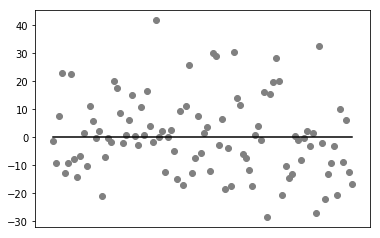

In [23]:
fig = df_results.plot(y='Zero', color='black')
fig.axes.scatter(x=df_results.index, y=df_results['Ŷ Previsto - Y Real'],color='grey')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_legend().set_visible(False)

In [24]:
fig.get_figure().savefig('graficos/result-reta/fig-reta-0-' + img_treat + '-'+ net +'-'+ activation +'.png')